In [1]:
import sys
import math
import itertools
from pathlib import Path
from typing import Any, Callable, Dict, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Add parent directory to path to find data_handling.py
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, load_state_npz, MeasurementDataset, MeasurementLoader

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Data Directory: {data_dir.resolve()}")

Running on: cpu
Data Directory: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_polish/tfim_16/measurements


In [10]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.normal_(self.W, std=0.01)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        """
        Symmetrized Free Energy: FE_sym(v) = -T * log( exp(-FE(v)/T) + exp(-FE(1-v)/T) )
        """
        v = v.to(dtype=self.W.dtype, device=self.W.device)

        # Precompute terms
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0) # Needed to compute (1-v)@W efficiently

        # 1. State v
        linear_v = v_W + c_mod
        term2_v = F.softplus(linear_v).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        fe_v = term1_v - term2_v

        # 2. State 1-v (flipped)
        # (1-v)@W = W_sum - v@W
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)
        fe_flipped = term1_f - term2_f

        # Combine: -T * logsumexp( -FE/T )
        # We stack -fe_v/T and -fe_flipped/T
        # But we can factor out 1/T later.
        # Here we compute -FE, so inputs to logsumexp are (-FE_v/T, -FE_flip/T)
        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)

        # Result is log(Z_v) * T essentially
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        # Note: We sample using the standard RBM conditionals.
        # The symmetry is enforced in the loss function (Free Energy).
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        # Score is proportional to -FreeEnergy
        return -self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")

        b_mod, c_mod = self._compute_effective_biases(cond)
        v_model = v_data.clone()

        noise_frac = aux_vars.get("noise_frac", 0.0)
        if noise_frac > 0:
            n_noise = int(v_data.shape[0] * noise_frac)
            if n_noise > 0:
                v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, rng)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = (fe_data - fe_model).mean()

        return loss, {}

    @torch.no_grad()
    def get_normalized_wavefunction(self, cond: torch.Tensor, all_states: torch.Tensor) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.unsqueeze(0)
        cond_exp = cond.expand(all_states.shape[0], -1)

        # Calculate unnormalized log prob using the symmetric free energy
        log_prob_unnorm = self.log_score(all_states, cond_exp)

        log_Z = torch.logsumexp(log_prob_unnorm, dim=0)
        log_prob = log_prob_unnorm - log_Z

        # Psi = sqrt(P)
        return torch.exp(0.5 * log_prob)

In [11]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train_loop(model, optimizer, loader, num_epochs, rng, lr_schedule_fn):
    global_step = 0
    model.train()
    training_noise_frac = 0.05

    print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
    print("-" * 35)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"{epoch+1:<6} | {tot_loss/len(loader):+.4f}     | {lr:.6f}")

    return model

def generate_all_states(num_qubits: int, device: torch.device):
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    if not gt_path.exists():
        return 0.0

    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true)

    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [12]:
# --- EXPERIMENT CONFIG ---
SYSTEM_SIZE = 16
TRAIN_SAMPLES = 20_000 # Use subset of the 5M for training speed
FILE_SUFFIX = "5000000" # As generated by your script

# Exact values from your data generation
h_support = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50]
h_novel   = [0.60, 0.70, 1.30, 1.40]

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

# Construct paths for SUPPORT (Training) files only
file_paths = []
print("Loading Training Data...")
for h in h_support:
    fname = f"tfim_{SYSTEM_SIZE}_h{h:.2f}_{FILE_SUFFIX}.npz"
    fpath = data_dir / fname

    if fpath.exists():
        file_paths.append(fpath)
        print(f"  + Found: {fname}")
    else:
        print(f"  ! MISSING: {fname} - Check generation or suffix")

if not file_paths:
    raise FileNotFoundError("No training files found.")

ds = MeasurementDataset(
    file_paths,
    load_measurements_npz,
    system_param_keys=["h"],
    samples_per_file=[TRAIN_SAMPLES] * len(file_paths)
)

loader = MeasurementLoader(
    ds,
    batch_size=1024,
    shuffle=True,
    drop_last=False,
    rng=rng
)
print(f"Dataset Size: {len(ds)} samples.")

Loading Training Data...
  + Found: tfim_16_h0.50_5000000.npz
  + Found: tfim_16_h0.80_5000000.npz
  + Found: tfim_16_h0.95_5000000.npz
  + Found: tfim_16_h1.00_5000000.npz
  + Found: tfim_16_h1.05_5000000.npz
  + Found: tfim_16_h1.20_5000000.npz
  + Found: tfim_16_h1.50_5000000.npz
Dataset Size: 140000 samples.


In [13]:
# CONFIG
N_EPOCHS = 50
HIDDEN_UNITS = 32
COND_WIDTH = 64
CD_K = 10
LR_INIT = 1e-2
LR_FINAL = 1e-4

model = ConditionalRBM(
    num_visible=SYSTEM_SIZE,
    num_hidden=HIDDEN_UNITS,
    cond_dim=1,
    conditioner_width=COND_WIDTH,
    k=CD_K
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR_INIT)

schedule_steps = N_EPOCHS * len(loader)
scheduler = get_sigmoid_curve(LR_INIT, LR_FINAL, schedule_steps, falloff=0.002)

print(f"Training Symmetric CRBM on 1D Chain (L={SYSTEM_SIZE})...")
model = train_loop(model, optimizer, loader, N_EPOCHS, rng, scheduler)
print("Training Complete.")

Training Symmetric CRBM on 1D Chain (L=16)...
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0327     | 0.009986
10     | -0.0095     | 0.009840
20     | +0.0086     | 0.007997
30     | -0.0092     | 0.002109
40     | -0.0204     | 0.000260
50     | -0.0169     | 0.000110
Training Complete.


In [14]:
import numpy as np

print("Generating full Hilbert space for exact evaluation...")
all_states = generate_all_states(SYSTEM_SIZE, device)

# Combine and sort all values
all_eval_h = sorted(list(set(h_support + h_novel)))

results = []
print(f"{'h':<6} | {'Type':<10} | {'Overlap':<10}")
print("-" * 35)

for h_val in all_eval_h:
    # GT file path (State vectors don't have sample count in name)
    gt_fname = f"tfim_{SYSTEM_SIZE}_h{h_val:.2f}.npz"
    gt_path = state_dir / gt_fname

    if not gt_path.exists():
        print(f"Skipping h={h_val:.2f} (No GT file)")
        continue

    overlap = compute_overlap(model, h_val, gt_path, all_states)

    # Classification logic: Is it in the training set?
    is_supp = any(np.isclose(h_val, s, atol=1e-5) for s in h_support)
    pt_type = "Support" if is_supp else "Novel"

    results.append({"h": h_val, "overlap": overlap, "type": pt_type})
    print(f"{h_val:<6.2f} | {pt_type:<10} | {overlap:.5f}")

df_res = pd.DataFrame(results)

Generating full Hilbert space for exact evaluation...
h      | Type       | Overlap   
-----------------------------------
0.50   | Support    | 0.99968
0.60   | Novel      | 0.99932
0.70   | Novel      | 0.99869
0.80   | Support    | 0.99748
0.95   | Support    | 0.99105
1.00   | Support    | 0.98810
1.05   | Support    | 0.98727
1.20   | Support    | 0.99454
1.30   | Novel      | 0.99558
1.40   | Novel      | 0.99562
1.50   | Support    | 0.99574


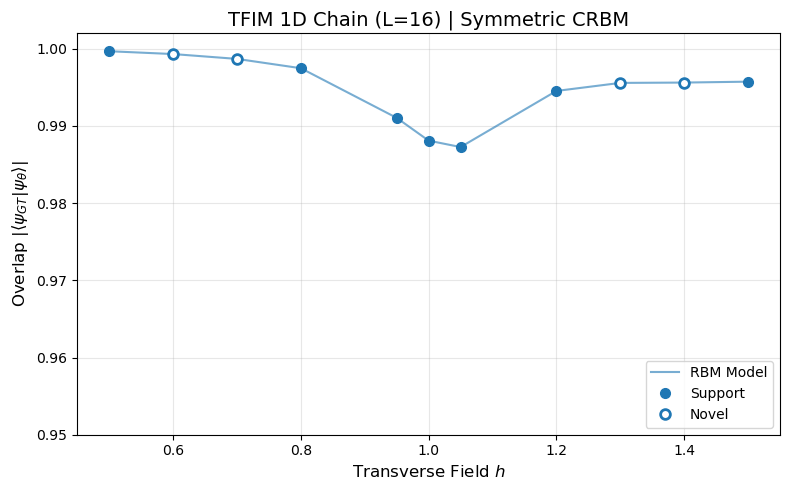

In [16]:
plt.figure(figsize=(8, 5), dpi=100)

supp = df_res[df_res["type"] == "Support"]
nov  = df_res[df_res["type"] == "Novel"]

# 1. Line
plt.plot(df_res["h"], df_res["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")

# 2. Support Points (Filled)
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")

# 3. Novel Points (Hollow / White Filled)
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white',
         markeredgewidth=2, markersize=7, label="Novel")

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.title(f"TFIM 1D Chain (L={SYSTEM_SIZE}) | Symmetric CRBM", fontsize=14)

# Requested Limits
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [17]:
from datetime import datetime

# 1. Generate timestamp and filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"crbm_tfim_16_{TRAIN_SAMPLES}_{timestamp}.pt"

# Ensure models directory exists
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)
save_path = models_dir / filename

# 2. Construct the save dictionary
save_dict = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "config": {
        "system_size": SYSTEM_SIZE,
        "num_visible": model.num_visible,
        "num_hidden": model.num_hidden,
        "cond_dim": 1,
        "conditioner_width": COND_WIDTH,
        "k_steps": model.k,
        "T_model": model.T,
        "train_samples": TRAIN_SAMPLES,
        "epochs": N_EPOCHS,
        "lr_init": LR_INIT,
        "h_support": h_support,
        "h_novel": h_novel
    },
    "results": results  # Saves the exact overlap numbers
}

# 3. Save to disk
torch.save(save_dict, save_path)
print(f"Model and results saved successfully to:\n{save_path.resolve()}")

Model and results saved successfully to:
/Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_polish/tfim_16/models/crbm_tfim_16_20000_20251211_192438.pt
